<a href="https://colab.research.google.com/github/maxiallard/QDax/blob/main/notebooks/Run_QDax_Example_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerated Quality-Diversity with QDax
Qdax is a project based on Jax and Brax to accelerate Quality-Diversity algorithms, a family of evolutionary algorithms. This notebook uses Quality-Diversity for Neuroevolution on the Ant task in Brax. 

In [1]:
#@title Installs and Imports
!pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()
import argparse
import os
import numpy as np
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt
from absl import logging
import functools
from typing import Callable, Optional
import pickle

import jax
import jax.numpy as jnp

try:
    import brax
except:
  !pip install git+https://github.com/google/brax.git@main |tail -n 1
  import brax

from brax.envs import wrappers
from brax.io import html

from brax.envs.env import Env
from brax.experimental.composer import register_default_components

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.tasks import BraxTask
from qdax.training.configuration import Configuration
from qdax.training import qd, emitters
from qdax.training.emitters_simple.iso_dd_emitter import iso_dd_emitter, create_iso_dd_fn
from qdax.envs.unidirectional_envs import ant, walker, hopper, halfcheetah, humanoid
from qdax.envs.omnidirectional_envs import ant as ant_omni
from qdax.envs.omnidirectional_envs import humanoid as humanoid_omni
    

if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()


QD_PARAMS = dict()

register_default_components()
clear_output()

#### Quality-Diversity Training Definition

In [2]:
#@title QD Training Definitions Fields

log_level = 'info' #@param ["info", "fatal", "error","warning","info","debug"]
batch_size = 1024 #@param {type:"number"}
env_name = 'ant_omni'#@param['ant', 'hopper', 'walker', 'halfcheetah', 'humanoid', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_epochs = 100 #@param {type:"integer"}
num_evaluations = None
log_frequency = 1 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
grid_shape = [100,100] #@param {type:"raw"}
min_bd = -15.0 #@param {type:"number"}
max_bd = 15.0 #@param {type:"number"}
#@markdown ---
#@markdown ### Enter a file path:
directory = "./" #@param {type:"string"}
exp_name = "Notebook_Experiment" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Task Setup with the chosen QD Settings

def get_num_epochs_and_evaluations(num_epochs, num_evaluations, population_size):
  if num_epochs is not None:
    num_evaluations = num_epochs * population_size
    return num_epochs, num_evaluations
  elif num_evaluations is not None:
    num_epochs = (num_evaluations // population_size) + 1
    return num_epochs, num_evaluations
  else:
    raise ValueError("One of the 2 following variables should be defined: num_epochs or num_evaluations")
results_saving_folder = directory

if not os.path.exists(results_saving_folder):
    raise FileNotFoundError(f"Folder {results_saving_folder} not found.")

levels = {'fatal': logging.FATAL,
            'error': logging.ERROR,
            'warning': logging.WARNING,
            'info': logging.INFO,
            'debug': logging.DEBUG}

logging.set_verbosity(levels[log_level])

population_size = batch_size

local_device_count = jax.local_device_count()
local_devices_to_use = local_device_count
process_count = jax.process_count()

brax_task = BraxTask(
    env_name=env_name,
    episode_length=episode_length,
    action_repeat=1,
    num_envs=population_size,
    local_devices_to_use=local_devices_to_use,
    process_count=process_count,
  )

num_epochs, num_evaluations = get_num_epochs_and_evaluations(num_epochs=num_epochs,
                                                               num_evaluations=num_evaluations,
                                                               population_size=batch_size)

logging.info(f"Options:\n"
               f"\t Log_level:{log_level}\n"
               f"\t Seed: {seed}\n"
               f"\t Batch_size:{batch_size}\n"
               f"\t Num_epochs:{num_epochs}\n"
               f"\t Num_evaluations:{num_evaluations}\n"
               f"\t Episode_length:{episode_length}\n"
               f"\t Log_frequency:{log_frequency}\n")

configuration = Configuration(env_name,
                                num_epochs,
                                episode_length,
                                action_repeat=1,
                                population_size=batch_size,
                                seed=seed,
                                log_frequency=log_frequency,
                                qd_params=QD_PARAMS,
                                min_bd=min_bd,
                                max_bd=max_bd,
                                grid_shape=tuple(grid_shape),
                                max_devices_per_host=None,
                                )

emitter_fn = emitters.get_emitter_iso_line_dd(
    population_size=population_size,
    iso_sigma=0.01,
    line_sigma=0.1,
  )

  # emitter_fn = functools.partial(iso_dd_emitter, 
  #   population_size=population_size, 
  #   iso_sigma=0.01, 
  #   line_sigma=0.1)

  # emitter_fn = create_iso_dd_fn(
  #   population_size=population_size, 
  #   iso_sigma=0.01, 
  #   line_sigma=0.1)

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:absl:Options:
	 Log_level:info
	 Seed: 42
	 Batch_size:1024
	 Num_epochs:100
	 Num_evaluations:102400
	 Episode_length:100
	 Log_frequency:1



In [4]:
training_state, inference_fn = qd.train(
                                    task=brax_task,
                                    emitter_fn=emitter_fn,
                                    configuration=configuration,
                                    progress_fn=None,
                                    experiment_name=exp_name,
                                    result_path=results_saving_folder,
                                  )

INFO:absl:Device count: 1, process count: 1 (id 0), local device count: 1, devices to be used count: 1
INFO:absl:Local devices to use: 1 
INFO:absl:Batch size on 1 device for env: 1024
INFO:absl:Initialize env time: 8.23992395401001 
INFO:absl:######### START QD ALGORITHM ############
INFO:absl: Initialisation with random policies
INFO:absl:Starting Main QD Loop
INFO:absl:<qdax.stats.timings.Timings object at 0x7fc1e2ec7910>
INFO:absl:Repertoire size: 1575 
INFO:absl:Scores [epoch, num_indivs, best fitness, QD score]:
 [[0.00000000e+00 3.10000000e+01 4.90770325e+02 1.49184512e+04]
 [1.00000000e+00 9.70000000e+01 4.91715515e+02 4.55661484e+04]
 [2.00000000e+00 1.70000000e+02 4.91866364e+02 7.85911953e+04]
 [3.00000000e+00 2.29000000e+02 4.92396362e+02 1.05235328e+05]
 [4.00000000e+00 2.82000000e+02 4.92411194e+02 1.28061125e+05]
 [5.00000000e+00 3.40000000e+02 4.92411194e+02 1.53336031e+05]
 [6.00000000e+00 3.82000000e+02 4.92411194e+02 1.72183781e+05]
 [7.00000000e+00 4.24000000e+02 4.

Variable str:  env_name value:  ant_omni
Variable str:  num_epochs value:  100
Variable str:  episode_length value:  100
Variable str:  population_size value:  1024
Variable str:  qd_params value:  {}
Variable str:  grid_shape value:  (100, 100)


In [5]:
#@title Loading the Results
#@markdown We load the saved repertoire and the solutions.
import glob
results = glob.glob(results_saving_folder+exp_name+"*/*")[0]
with open(results+'/training_state.pkl','rb') as f:
    file = pickle.load(f)
repertoire = file.repertoire

## Visualization

In [6]:
#@title Interactive Behavioural Repertoire Visualization
global selected_ind,selected_x,selected_y
selected_ind = 0
selected_x,selected_y = 0,0
def bd_interactive(repertoire,use_web=False,high_dim=False):
    x_bd = [0,1]
    y_bd = [0,1] 
    fit = [0.2,-1]
    
    if not high_dim:

        mask = jnp.where(~jnp.isnan(repertoire.fitness),1,0)

        counter = 0
        for r,row in enumerate(mask):
            for c,col in enumerate(row):
                if col>0:
                    x_bd.append(r/(repertoire.grid_shape[0]-1))
                    y_bd.append(c/(repertoire.grid_shape[0]-1))
                    fit.append(repertoire.fitness[(r,c)]/(jnp.nanmax(repertoire.fitness)))
                    counter+=1

        bd_archive = [x_bd, y_bd]
        # fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.grid()
        im = ax.scatter(bd_archive[0], bd_archive[1],c=fit,s=30,cmap=plt.cm.viridis,marker='s')
        im.set_clim(0, 1)
        ax.set_aspect(1)
        fig.colorbar(im,ax=ax)
        text=ax.text(0,0, "", va="bottom", ha="left")
    else:
        archive = repertoire.fitness
        resolutions= list(repertoire.grid_shape)#[10,10,10,10]
        grid = np.empty((np.prod(resolutions[0::2]),np.prod(resolutions[1::2])))
        for row in range(resolutions[0]):
            for col in range(resolutions[1]):
                space = resolutions[0]
                for i in range(space):
                    grid[(row*space):(row+1)*space,(col*space):(col+1)*space] = archive[row,col,:,:]

        fig=plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        c = ax.pcolor(grid,vmin=0, vmax=200, edgecolors = None, antialiaseds=True)
        fig.colorbar(c, ax=ax)
        ax.set_aspect(1)
        text=ax.text(0,0, "", va="bottom", ha="left")


    def visualize(event):
        global selected_ind,selected_x,selected_y
        tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        selected_x = int(event.xdata*repertoire.grid_shape[0])
        selected_y = int(event.ydata*repertoire.grid_shape[1])
        if(high_dim):
            resolutions=list(repertoire.grid_shape)
            row1 = selected_x//100
            col1 = selected_y//100
            row2= (selected_x//resolutions[0])%resolutions[2]
            col2 = (selected_y//resolutions[1])%resolutions[3]
            selected_ind = np.ravel_multi_index((col1,row1,col2,row2),repertoire.grid_shape)
            
        else:
            selected_ind = np.ravel_multi_index((selected_x,selected_y),repertoire.grid_shape)
        ax.set_xlabel("Selected BD {},{} which is individual nr : {}".format(selected_x,selected_y,selected_ind))
        if(use_web):
            html_file = visualize_env(selected_ind)
            with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as f:
                url = 'file://' + f.name
                f.write(html_file)
            webbrowser.open(url)

    cid = fig.canvas.mpl_connect('button_press_event', visualize)
    plt.show()


In [7]:
def visualize_env(selected_ind,inference,brax_task):
    env = brax_task.generate_env(env_name)
    selected_params = jax.tree_map(lambda x: x[selected_ind],repertoire.archive)
    fitness = repertoire.fitness.ravel()[selected_ind]
    inference_fn = inference
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(inference_fn)
    rollout = []
    rng = jax.random.PRNGKey(seed=42)
    state = jit_env_reset(rng=rng)

    done_list=[]
    
    for _ in range(episode_length):
        rollout.append(state)
        act_rng, rng = jax.random.split(rng)
        act = jit_inference_fn((selected_params), state.obs, act_rng)
        state = jit_env_step(state, act)
    print("Final BD: ", rollout[-1].info['bd'])
    print("Fitness: {}".format(fitness))
    return html.render(env.sys, [s.qp for s in rollout])
    

In [9]:
from qdax.training.qd import make_params_and_inference_fn
inference_fn = make_params_and_inference_fn(brax_task.core_env.observation_size,brax_task.core_env.action_size)

###Select the desired behaviour on the 2D Map and then run the next cell. 
To visualise one of the solutions from the grid, please select the individual by clicking on it. Once you have clicked on the individual, you will see the Id of the individual on the x-axis title of the plot. You can then run the next cell to see the generated behaviour in HTML format or save it.



In [10]:
if(env_name=='ant'):
  high_dim=True
else:
  high_dim=False

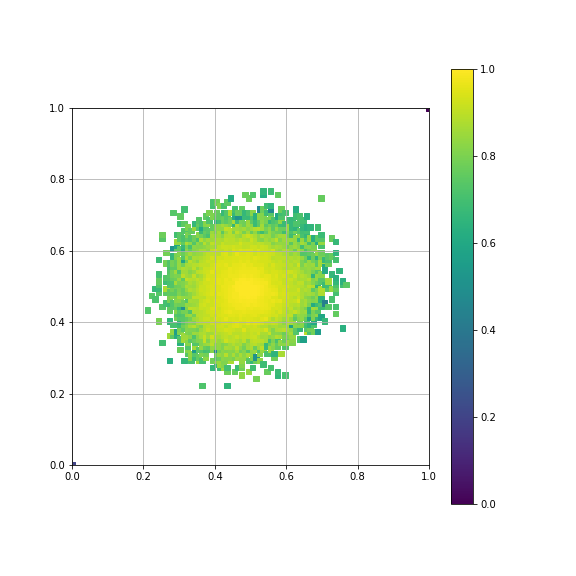

In [11]:
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
bd_interactive(repertoire,use_web=False,high_dim=high_dim)

In [12]:
print("Selected Individual: {}, with normalized BD {:.4f} and {:.4f}".format(selected_ind,(selected_x)/100*30-15,selected_y/100*30-15))
html_file = visualize_env(selected_ind,inference_fn,brax_task)
display(HTML(html_file ))

Selected Individual: 5762, with normalized BD 2.1000 and 3.6000
Final BD:  [4.042328   0.85599697]
Fitness: 412.5693664550781


### Saving HTML File

In [ ]:
path = os.path.abspath('./Ant_Omni_Behaviour.html')
url = 'file://' + path

with open(path, 'w') as f:
    f.write(html_file)